In [121]:
import numpy as np
import matplotlib.pyplot as plt
import tskit, pyslim, msprime

In [122]:
file = '../data/sim_10000K_0d_0.01s_0.5h_2B_0u_1q_100000L_1.25e-08r_0.75f_0n'
extra='_25k_2.5e-08U'

## infer effective population size with relate

In [131]:
# truth
filename=file+'.dynamics'
dynamics = np.loadtxt(filename, skiprows=1) #truth during forward simulation (t,N,p)
ts = dynamics[:,0]
ts = dynamics[:,0][-1] - ts #convert forward time to backwards time
Ns = dynamics[:,1]
ps = dynamics[:,2]

In [132]:
# relate
filename=file+extra+'_popsize.coal'
epochs = np.loadtxt(filename, skiprows=1, max_rows=1)
coalrates = np.loadtxt(filename, skiprows=2)[2:] #note that the coal line starts with two 0s, indicating the popns being compared (https://myersgroup.github.io/relate/modules.html)

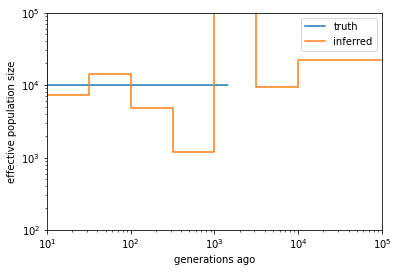

In [133]:
plt.plot(ts, Ns, label='truth')

plt.step(epochs, 0.5/coalrates, where='pre', label='inferred') 

plt.xscale('log')
plt.yscale('log')
plt.xlabel('generations ago')
plt.ylabel('effective population size')
plt.xlim(1e1, 1e5)
plt.ylim(1e2,1e5)
plt.legend()
plt.show()

## infer allele frequency dynamics with clues (via relate)

and after running CLUES on the selected site we get this allele frequency

In [138]:
freqs[np.argmax(post, axis=0)]

array([0.77850796, 0.77850796, 0.77850796, 0.77850796, 0.77850796,
       0.77850796, 0.77850796, 0.77179693, 0.77179693, 0.77179693,
       0.77179693, 0.77179693, 0.77179693, 0.77179693, 0.77179693,
       0.77179693, 0.77179693, 0.77179693, 0.77179693, 0.77179693,
       0.77179693, 0.77179693, 0.77179693, 0.77179693, 0.77179693,
       0.77179693, 0.77179693, 0.77179693, 0.77179693, 0.77179693,
       0.77179693, 0.77179693, 0.77179693, 0.77179693, 0.77179693,
       0.77179693, 0.77179693, 0.77179693, 0.77179693, 0.77179693,
       0.77179693, 0.77179693, 0.76508589, 0.76508589, 0.76508589,
       0.76508589, 0.76508589, 0.76508589, 0.76508589, 0.76508589,
       0.76508589, 0.76508589, 0.76508589, 0.76508589, 0.76508589,
       0.75837486, 0.75837486, 0.75837486, 0.75837486, 0.75837486,
       0.75837486, 0.75837486, 0.75837486, 0.75837486, 0.75837486,
       0.75837486, 0.75837486, 0.75837486, 0.75166382, 0.75166382,
       0.75166382, 0.75166382, 0.75166382, 0.75166382, 0.75166

In [134]:
freqs = np.load(filename.replace('.coal','_clues.freqs.npy'))
clues_epochs = np.load(filename.replace('.coal','_clues.epochs.npy'))
post = np.load(filename.replace('.coal','_clues.post.npy'))

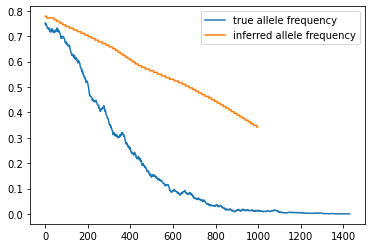

In [135]:
plt.plot(ts, ps, label='true allele frequency')
plt.step(clues_epochs[:-1], freqs[np.argmax(post, axis=0)], label='inferred allele frequency')
plt.legend()
plt.show()

So clearly something going wrong here -- it looks from Stern et al 2019 fig 7 that CLUES can infer allele frequency trajectories well for selection coefficients as large as 0.03. But note that was clues-v0, which used ARGweaver trees. Now CLUES uses Relate trees, and Hejase et al 2022 show that CLUES is much worse, and greatly understimates selection coefficients for selection coefficients even as large as 0.01. This is due to tree errors, as CLUES does well with true trees (as shown in that paper). So let's look at CLUES run on the true coalescent times:

# clues (via true coalescence times)

In [128]:
freqs_true = np.load(filename.replace('.coal','_clues_true.freqs.npy'))
epochs_true = np.load(filename.replace('.coal','_clues_true.epochs.npy'))
post_true = np.load(filename.replace('.coal','_clues_true.post.npy'))

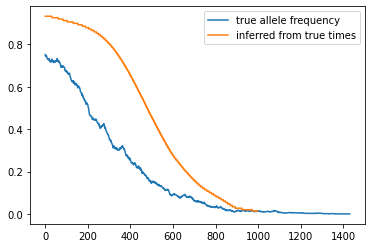

In [130]:
plt.plot(ts,ps, label='true allele frequency')
plt.step(epochs_true[:-1], freqs_true[np.argmax(post_true, axis=0)], label='inferred from true times')
plt.legend()
plt.show()

and it would probably be much better if we gave it the current popn freq (0.75) as it seems like it gets the slope right but the intercept wrong.

# clues-v0 (via argweaver trees)

I'm now curious how ARGweaver trees would compare

In [67]:
import h5py
h5file = "../data/sim_10000K_0d_0.01s_0.5h_2B_0u_1q_100000L_1.25e-08r_0.75f_0n_25k_2.5e-08U_argweaver/out.clues.h5"
h5 = h5py.File(h5file,'r')

In [68]:
xHats = h5.attrs['xHat']
ts = h5.attrs['t']

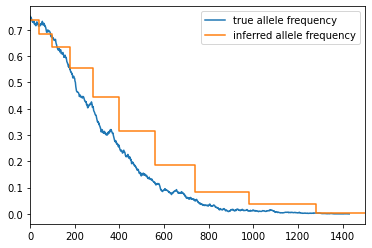

In [69]:
maxt=dynamics[:,0][-1]
plt.plot(maxt-dynamics[:,0],dynamics[:,2], label='true allele frequency')
plt.step(ts[:-1], xHats, where='post', label='inferred allele frequency')
plt.legend()
plt.xlim([0,1500])
plt.show()

damn!

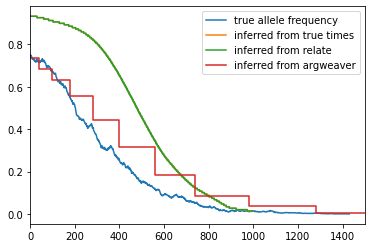

In [74]:
maxt=dynamics[:,0][-1]
plt.plot(maxt-dynamics[:,0],dynamics[:,2], label='true allele frequency')
plt.step(epochs[:-1], freqs[np.argmax(post, axis=0)], label='inferred from true times')
plt.step(epochs[:-1], freqs[np.argmax(post, axis=0)], label='inferred from relate')
plt.step(ts[:-1], xHats, where='post', label='inferred from argweaver')
plt.legend()
plt.xlim([0,1500])
plt.show()

## view selected tree, inferred from relate

In [56]:
from IPython.display import IFrame
plot_fn = file+extra+'_popsize.pdf'
IFrame(plot_fn, width=600, height=400)

## detect selection with relate

evidence of selection on all SNPs over time (log10 p values), https://myersgroup.github.io/relate/modules.html#Selection

In [57]:
sele = np.loadtxt(file+extra+'_popsize.sele', skiprows=1)

OSError: ../data/sim_10000K_0d_0.01s_0.5h_2B_0u_1q_100000L_1.25e-08r_0.75f_0n_25k_2.5e-08U_popsize.sele not found.

pull out evidence of selection over all time (last column)

In [58]:
# for i in range(sele.shape[1]):
plt.scatter(sele[:,0],sele[:,-1])
plt.show()

NameError: name 'sele' is not defined

In [59]:
minsele = np.min(sele[:,-1])
[i[0] for i in sele if i[-1]==minsele]

NameError: name 'sele' is not defined